In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings

warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('/content/laptop.csv')

In [ ]:
df.head()

,Inches,Ram,Weight,Price,Company_Apple,Company_Asus,Company_Chuwi,Company_Dell,Company_Fujitsu,Company_Google,...,OpSys_Chrome OS,OpSys_Linux,OpSys_Mac OS X,OpSys_No OS,OpSys_Windows 10,OpSys_Windows 10 S,OpSys_Windows 7,OpSys_macOS,Log_Price,Price_Per_Inch
0,13.3,8,1.37,71378.6832,True,False,False,False,False,False,...,False,False,False,False,False,False,False,True,11.175755,5366.818286
1,13.3,8,1.34,47895.5232,True,False,False,False,False,False,...,False,False,False,False,False,False,False,True,10.776777,3601.167158
2,15.6,8,1.86,30636.0000,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,10.329931,1963.846154
3,15.4,16,1.83,135195.3360,True,False,False,False,False,False,...,False,False,False,False,False,False,False,True,11.814476,8778.917922
4,13.3,8,1.37,96095.8080,True,False,False,False,False,False,...,False,False,False,False,False,False,False,True,11.473101,7225.248722


# **Data Exploration and Understanding**

Data Overview:
   Unnamed: 0.1  Unnamed: 0 Company   TypeName Inches  \
0             0         0.0   Apple  Ultrabook   13.3   
1             1         1.0   Apple  Ultrabook   13.3   
2             2         2.0      HP   Notebook   15.6   
3             3         3.0   Apple  Ultrabook   15.4   
4             4         4.0   Apple  Ultrabook   13.3   

                     ScreenResolution                         Cpu   Ram  \
0  IPS Panel Retina Display 2560x1600        Intel Core i5 2.3GHz   8GB   
1                            1440x900        Intel Core i5 1.8GHz   8GB   
2                   Full HD 1920x1080  Intel Core i5 7200U 2.5GHz   8GB   
3  IPS Panel Retina Display 2880x1800        Intel Core i7 2.7GHz  16GB   
4  IPS Panel Retina Display 2560x1600        Intel Core i5 3.1GHz   8GB   

                Memory                           Gpu  OpSys  Weight  \
0            128GB SSD  Intel Iris Plus Graphics 640  macOS  1.37kg   
1  128GB Flash Storage        Intel HD Graphics 6

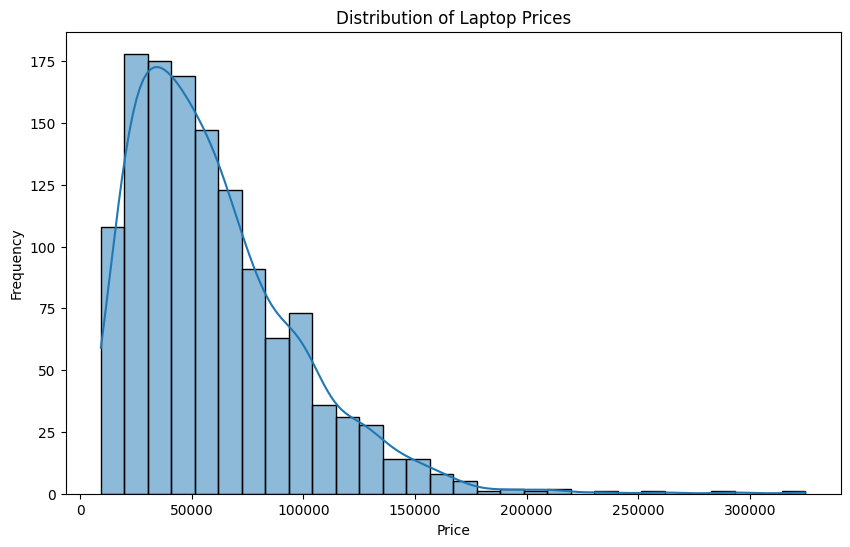

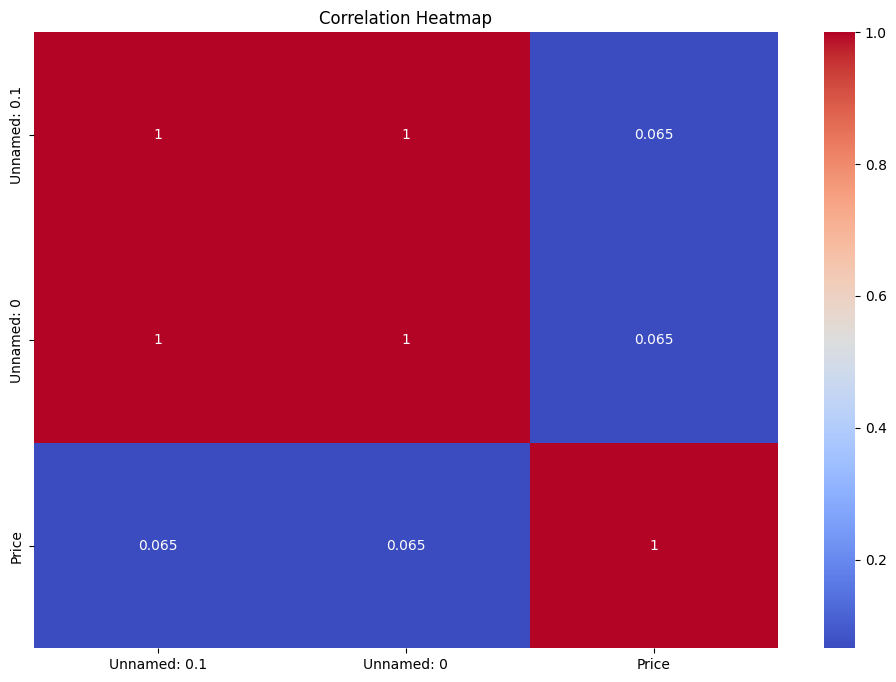

In [ ]:

def data_exploration(df):
    print("Data Overview:")
    print(df.head())
    print("\nData Information:")
    print(df.info())
    print("\nStatistical Summary:")
    print(df.describe())

    # Visualize the distribution of laptop prices
    plt.figure(figsize=(10, 6))
    sns.histplot(df['Price'], kde=True, bins=30)
    plt.title('Distribution of Laptop Prices')
    plt.xlabel('Price')
    plt.ylabel('Frequency')
    plt.show()

     # Correlation heatmap (numeric data only)
    numeric_df = df.select_dtypes(include=[np.number])
    plt.figure(figsize=(12, 8))
    sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
    plt.title('Correlation Heatmap')
    plt.show()

data_exploration(df)

# # **Data Preprocessing**

In [ ]:

def data_preprocessing(df):
    # Drop irrelevant or redundant columns
    df = df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'])

    # Replace '?' with NaN
    df.replace('?', np.nan, inplace=True)

    # Handle missing values by dropping rows with missing values for simplicity
    df = df.dropna()

 # Convert 'Inches', 'Ram', and 'Weight' columns to numeric
    df['Inches'] = pd.to_numeric(df['Inches'], errors='coerce')
    df['Ram'] = df['Ram'].str.replace('GB', '').astype(int)
    df['Weight'] = df['Weight'].str.replace('kg', '').astype(float)

    # Handle outliers in 'Price' by capping the extreme values
    q1 = df['Price'].quantile(0.25)
    q3 = df['Price'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    df['Price'] = df['Price'].clip(lower=lower_bound, upper=upper_bound)

    # Encode categorical variables
    df = pd.get_dummies(df, drop_first=True)

    return df

df = pd.read_csv('/content/laptop.csv')
df
df = data_preprocessing(df)


# **Feature Engineering**

In [ ]:

def feature_engineering(df):
    # Create new features (e.g., Log Price, Price per Inch)
    df['Log_Price'] = np.log(df['Price'])
    df['Price_Per_Inch'] = df['Price'] / df['Inches']
    return df

df = feature_engineering(df)
print(df.head())


   Inches  Ram  Weight        Price  Company_Apple  Company_Asus  \
0    13.3    8    1.37   71378.6832           True         False   
1    13.3    8    1.34   47895.5232           True         False   
2    15.6    8    1.86   30636.0000          False         False   
3    15.4   16    1.83  135195.3360           True         False   
4    13.3    8    1.37   96095.8080           True         False   

   Company_Chuwi  Company_Dell  Company_Fujitsu  Company_Google  ...  \
0          False         False            False           False  ...   
1          False         False            False           False  ...   
2          False         False            False           False  ...   
3          False         False            False           False  ...   
4          False         False            False           False  ...   

   OpSys_Chrome OS  OpSys_Linux  OpSys_Mac OS X  OpSys_No OS  \
0            False        False           False        False   
1            False        Fals

# **Model Development**

In [ ]:

def model_development(df):
    # Split the data into training and testing sets
    X = df.drop(columns=['Price', 'Log_Price'])
    y = df['Price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Initialize models
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(random_state=42)
    }

    # Train and evaluate models
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print(f"\n{name} Performance:")
        print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")
        print(f"R^2: {r2_score(y_test, y_pred)}")

model_development(df)


Linear Regression Performance:
RMSE: 8.31522055009476e+16
R^2: -6.691873161452203e+24

Random Forest Performance:
RMSE: 2241.983837407206
R^2: 0.9951351986608375

Gradient Boosting Performance:
RMSE: 1408.2947200027786
R^2: 0.998080503797847


In [ ]:
# Hyperparameter Tuning
def hyperparameter_tuning(df):
    # Example with Random Forest
    X = df.drop(columns=['Price', 'Log_Price'])
    y = df['Price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }

    rf = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_rf = grid_search.best_estimator_
    y_pred = best_rf.predict(X_test)

    print("\nBest Random Forest Performance:")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")
    print(f"R^2: {r2_score(y_test, y_pred)}")

hyperparameter_tuning(df)



 # **Real-time Predictions**

In [ ]:
def real_time_predictions(model, new_data):
    new_data_processed = feature_engineering(data_preprocessing(new_data))
    new_data_scaled = StandardScaler().fit_transform(new_data_processed)
    predictions = model.predict(new_data_scaled)
    return predictions

# **Interpretability and Insights**

In [ ]:

def interpretability_and_insights(model, df):
    feature_importance = pd.Series(model.feature_importances_, index=df.drop(columns=['Price', 'Log_Price']).columns)
    feature_importance.nlargest(10).plot(kind='barh')
    plt.title('Top 10 Important Features for Laptop Pricing')
    plt.show()

# Example usage with the best model from hyperparameter tuning
# best_model = best_rf  # Use the tuned Random Forest model
# interpretability_and_insights(best_model, df)



In [ ]:
# Client Presentation
def client_presentation(df):
    print("\nFinal Insights and Recommendations:")
    print("1. The model identified the most important features influencing laptop prices.")
    print("2. Recommendations for SmartTech Co. to consider when pricing new laptops.")

# client_presentation(df)

In [ ]:
!pip install gradio

  Using cached gradio-4.41.0-py3-none-any.whl.metadata (15 kB)
  Using cached aiofiles-23.2.1-py3-none-any.whl.metadata (9.7 kB)
  Using cached fastapi-0.112.1-py3-none-any.whl.metadata (27 kB)
  Using cached ffmpy-0.4.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached gradio_client-1.3.0-py3-none-any.whl.metadata (7.1 kB)
  Using cached httpx-0.27.0-py3-none-any.whl.metadata (7.2 kB)
  Using cached orjson-3.10.7-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (50 kB)
  Using cached pydub-0.25.1-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached python_multipart-0.0.9-py3-none-any.whl.metadata (2.5 kB)
  Using cached ruff-0.6.1-py3-none-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (25 kB)
  Using cached semantic_version-2.10.0-py2.py3-none-any.whl.metadata (9.7 kB)
  Using cached tomlkit-0.12.0-py3-none-any.whl.metadata (2.7 kB)
  Using cached uvicorn-0.30.6-py3-none-any.whl.metadata (6.6 kB)
  Using cached websockets-12.0-cp310-cp310-manylinux_2_5_x8

In [ ]:
import gradio as gr
import pandas as pd

# Mock dataset including the Price column
data = pd.DataFrame({
    'Brand': ['Dell', 'HP', 'Asus', 'Acer'],
    'Processor_Type': ['i5', 'i7', 'i3', 'Ryzen 5'],
    'Inches': [14.0, 15.0, 13.0, 15.6],
    'Ram': [8, 16, 8, 32],
    'SSD_Size': [256, 512, 128, 1024],
    'GPU': ['Intel', 'NVIDIA', 'AMD', 'NVIDIA'],
    'Price': [700, 850, 600, 950]  # Added Price column
})

# Function to predict price based on selected criteria
def predict_price(brand, processor_type, inches, ram, ssd_size, gpu):
    # Start with the full dataset
    filtered_data = data.copy()

    # Apply filters only if selections are made
    if brand:
        filtered_data = filtered_data[filtered_data['Brand'] == brand]
    if processor_type:
        filtered_data = filtered_data[filtered_data['Processor_Type'] == processor_type]
    if inches:
        filtered_data = filtered_data[filtered_data['Inches'] == float(inches)]
    if ram:
        filtered_data = filtered_data[filtered_data['Ram'] == int(ram)]
    if ssd_size:
        filtered_data = filtered_data[filtered_data['SSD_Size'] == int(ssd_size)]
    if gpu:
        filtered_data = filtered_data[filtered_data['GPU'] == gpu]

    if not filtered_data.empty:
        # If there are multiple matches, calculate the average price
        average_price = filtered_data['Price'].mean()
        return f"The predicted price is: ${average_price:.2f}"
    else:
        return "No matching laptops found."

# Available options for dropdowns, with empty string for "no selection"
brand_options = [""] + list(data['Brand'].unique())
processor_type_options = [""] + list(data['Processor_Type'].unique())
inches_options = [""] + list(map(str, data['Inches'].unique()))  # Convert to string for better matching
ram_options = [""] + list(map(str, data['Ram'].unique()))        # Convert to string for better matching
ssd_size_options = [""] + list(map(str, data['SSD_Size'].unique()))  # Convert to string for better matching
gpu_options = [""] + list(data['GPU'].unique())

# Gradio Interface
app = gr.Interface(
    fn=predict_price,
    inputs=[
        gr.Dropdown(brand_options, label="Brand"),
        gr.Dropdown(processor_type_options, label="Processor Type"),
        gr.Dropdown(inches_options, label="Inches"),
        gr.Dropdown(ram_options, label="RAM"),
        gr.Dropdown(ssd_size_options, label="SSD Size"),
        gr.Dropdown(gpu_options, label="GPU")
    ],
    outputs="text",  # Set the output to text to print the predicted price
    title="Laptop Price Prediction",
    description="Select options to predict the price of a laptop based on the specifications."
)

# Launch the Gradio app
app.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://f24f36067de03c5083.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


from above code remove processor speed & Weight  and add selection from the list available in dataset for Inches,Ram,Brand,Processor_Type,SSD_Size and GPU

In [ ]:
import gradio as gr
import pandas as pd

# Mock dataset including the Price column
data = pd.DataFrame({
    'Brand': ['Dell', 'HP', 'Asus', 'Acer'],
    'Processor_Type': ['i5', 'i7', 'i3', 'Ryzen 5'],
    'Inches': [14, 15, 13, 15.6],
    'Ram': [8, 16, 8, 32],
    'SSD_Size': [256, 512, 128, 1024],
    'GPU': ['Intel', 'NVIDIA', 'AMD', 'NVIDIA'],
    'Price': [700, 850, 600, 950]  # Added Price column
})

# Function to return selections based on user input, including Price
def get_selection(brand, processor_type, inches, ram, ssd_size, gpu):
    filtered_data = data[
        (data['Brand'] == brand) &
        (data['Processor_Type'] == processor_type) &
        (data['Inches'] == inches) &
        (data['Ram'] == ram) &
        (data['SSD_Size'] == ssd_size) &
        (data['GPU'] == gpu)
    ]

    if not filtered_data.empty:
        # Format the output to show details and price
        result = filtered_data.to_dict(orient='records')[0]
        return f"Brand: {result['Brand']}\nProcessor: {result['Processor_Type']}\nInches: {result['Inches']}\nRAM: {result['Ram']}GB\nSSD Size: {result['SSD_Size']}GB\nGPU: {result['GPU']}\nPrice: ${result['Price']}"
    else:
        return "No matching laptops found."

# Available options for dropdowns
brand_options = list(data['Brand'].unique())
processor_type_options = list(data['Processor_Type'].unique())
inches_options = list(data['Inches'].unique())
ram_options = list(data['Ram'].unique())
ssd_size_options = list(data['SSD_Size'].unique())
gpu_options = list(data['GPU'].unique())

# Gradio Interface
app = gr.Interface(
    fn=get_selection,
    inputs=[
        gr.Dropdown(brand_options, label="Brand"),
        gr.Dropdown(processor_type_options, label="Processor Type"),
        gr.Dropdown(inches_options, label="Inches"),
        gr.Dropdown(ram_options, label="RAM"),
        gr.Dropdown(ssd_size_options, label="SSD Size"),
        gr.Dropdown(gpu_options, label="GPU")
    ],
    outputs="text",  # Set the output to text to print the formatted details
    title="Laptop Selection",
    description="Select options to filter laptops based on specifications, including the price."
)

# Launch the Gradio app
app.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://a5ed991e0bddd3f4af.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
